**Alzheimer's Multi Catergorical Classification**

**Model Testing Code**

**Device - Nvidia RTX 3050 GPU**

**Classes - [Dementia, Mild Dementia, Very Mild Dementia, Cognitively Normal**]

In [34]:
import glob
import time
import numpy as np
import pandas as pd
import nibabel as nib
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split

In [35]:
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout, Concatenate

In [36]:
tf.debugging.set_log_device_placement(True)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.experimental.list_logical_devices('GPU'))

Num GPUs Available:  1
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


In [37]:
#sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

In [38]:
file_names = glob.glob("Train_Data/*.nii")
print(len(file_names))

558


In [39]:
train_y_df = pd.read_csv("Train_csv_model.csv")
train_y_df["CDRTOT"].value_counts()

2.0    194
0.5    127
1.0    126
0.0    111
Name: CDRTOT, dtype: int64

In [40]:
# shapes = {}

# for i in file_names:
#     nii_data = nib.load(i).get_fdata()

#     if (shapes.get(nii_data.shape) == None):
#         shapes[nii_data.shape] = 1
#     else:
#         shapes[nii_data.shape] = shapes[nii_data.shape] + 1

# print(shapes)

In [41]:
train_y_list = train_y_df.values.tolist()
print(train_y_list[0])
print(train_y_list[0][3:11])

['OAS30001_MR_d0129', 'OAS30001_UDSb4_d0000', 0, 65.19, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.0]
[65.19, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0]


In [42]:
X = []
Y = []

# range(len(file_names))
# for i in range(len(file_names)):
for i in range(100):
    nii_data = nib.load(file_names[i]).get_fdata()
    nii_data_shape = nii_data.shape

    nii_data_images = []

    (required_x, required_y, required_z) = (88, 120, 2)

    lower_limit_x = int(nii_data_shape[0] / 2) - required_x
    upper_limit_x = int(nii_data_shape[0] / 2) + required_x

    lower_limit_y = int(nii_data_shape[1] / 2) - required_y
    upper_limit_y = int(nii_data_shape[1] / 2) + required_y

    lower_limit_z = int(nii_data_shape[2] / 2) - required_z
    upper_limit_z = int(nii_data_shape[2] / 2) + required_z

    for z in range(lower_limit_z, upper_limit_z):
        X.append([nii_data[lower_limit_x:upper_limit_x, lower_limit_y:upper_limit_y, z], np.array(train_y_list[i][3:11])])

        if (train_y_list[i][-1] == 0):
            Y.append([1, 0, 0, 0])
        elif (train_y_list[i][-1] == 0.5):
            Y.append([0, 1, 0, 0])
        elif (train_y_list[i][-1] == 1):
            Y.append([0, 0, 1, 0])
        elif (train_y_list[i][-1] == 2):
            Y.append([0, 0, 0, 1])
        else:
            print("Unknown CDR")
            break

In [43]:
print(len(X))
print(len(Y))

400
400


In [44]:
x, test_x, y, test_y = train_test_split(X, Y, test_size = 0.2, random_state = 42)

print(len(x))
print(len(y))
print(len(test_x))
print(len(test_y))

320
320
80
80


In [45]:
train_x, val_x, train_y, val_y = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [46]:
train_x_image = []
val_x_image = []

train_x_data = []
val_x_data = []

for i, j in train_x:
    train_x_image.append(i)
    train_x_data.append(j)

for i, j in val_x:
    val_x_image.append(i)
    val_x_data.append(j)

train_x_image = np.array(train_x_image) / 255
train_x_data = np.array(train_x_data)

val_x_image = np.array(val_x_image) / 255
val_x_data = np.array(val_x_data)

train_y = np.array(train_y)
val_y = np.array(val_y)

Xtr = [train_x_image, train_x_data]
Xval = [val_x_image, val_x_data]

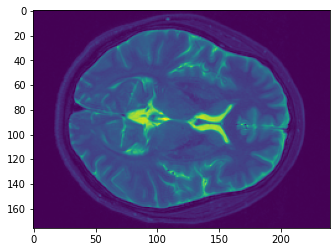

In [47]:
plt.imshow(train_x_image[0] * 255)

In [48]:
# Image NN
input_image = Input(shape = (176, 240, 1), name = "input_image")
conv1 = Conv2D(32, (3, 3), strides = 1, padding = 'same', activation = 'relu')(input_image)
maxpool1 = MaxPool2D((2, 2), strides = 2, padding = 'same')(conv1)

conv2 = Conv2D(32, (3, 3), strides = 1, padding = 'same', activation = 'relu')(maxpool1)
maxpool2 = MaxPool2D((2, 2), strides = 2, padding = 'same')(conv2)

conv3 = Conv2D(32, (3, 3), strides = 1, padding = 'same', activation = 'relu')(maxpool2)
maxpool3 = MaxPool2D((2, 2), strides = 2, padding = 'same')(conv3)

conv4 = Conv2D(32, (3, 3), strides = 1, padding = 'same', activation = 'relu')(maxpool3)
maxpool4 = MaxPool2D((2, 2), strides = 2, padding = 'same')(conv4)

dense_image_1 = Dense(512, activation = 'relu')(maxpool4)
dense_image_2 = Dense(128, activation = 'relu')(dense_image_1)

flatten1 = Flatten()(dense_image_2)
dense_image_3 = Dense(64, activation = 'relu')(flatten1)
dropout1 = Dropout(0.5)(dense_image_3)
dense_image_4 = Dense(64, activation = 'relu')(dropout1)

model_image = Model(inputs = input_image, outputs = dense_image_4)

# Data NN

input_data = Input(shape = (8,), name = "input_data")
dense_data_1 = Dense(16, activation = 'relu')(input_data)
dense_data_2 = Dense(8, activation = 'relu')(dense_data_1)
dense_data_3 = Dense(8, activation = 'relu')(dense_data_2)

model_data = Model(inputs = input_data, outputs = dense_data_3)

concat1 = Concatenate()([model_image.output, model_data.output])
dense_concat = Dense(units = 4, activation = 'sigmoid')(concat1)

model = Model(inputs = [input_image, input_data], outputs = dense_concat)
model.compile(optimizer = "rmsprop", loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.summary()

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/repli

In [49]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2, verbose=1, factor=0.5, min_lr=0.000001)

In [50]:
start_time = time.time()

history = model.fit(x = Xtr, y = train_y, epochs = 25, validation_data = (Xval, val_y), callbacks = [learning_rate_reduction])

end_time = time.time()

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in 

In [51]:
print("The time of execution of above program is {} s".format((end_time - start_time)))

The time of execution of above program is 18.093602418899536 s


In [52]:
test_x_image = []
test_x_data = []

for i, j in test_x:
    test_x_image.append(i)
    test_x_data.append(j)

test_x_image = np.array(test_x_image) / 255
test_x_data = np.array(test_x_data)

test_y = np.array(test_y)

Xte = [test_x_image, test_x_data]

print("Loss of the model is - ", model.evaluate(Xte, test_y)[0])
print("Accuracy of the model is - ", model.evaluate(Xte, test_y)[1] * 100, '%')

# model.save('/kaggle/working/Final_Multi_Model.keras')

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Option

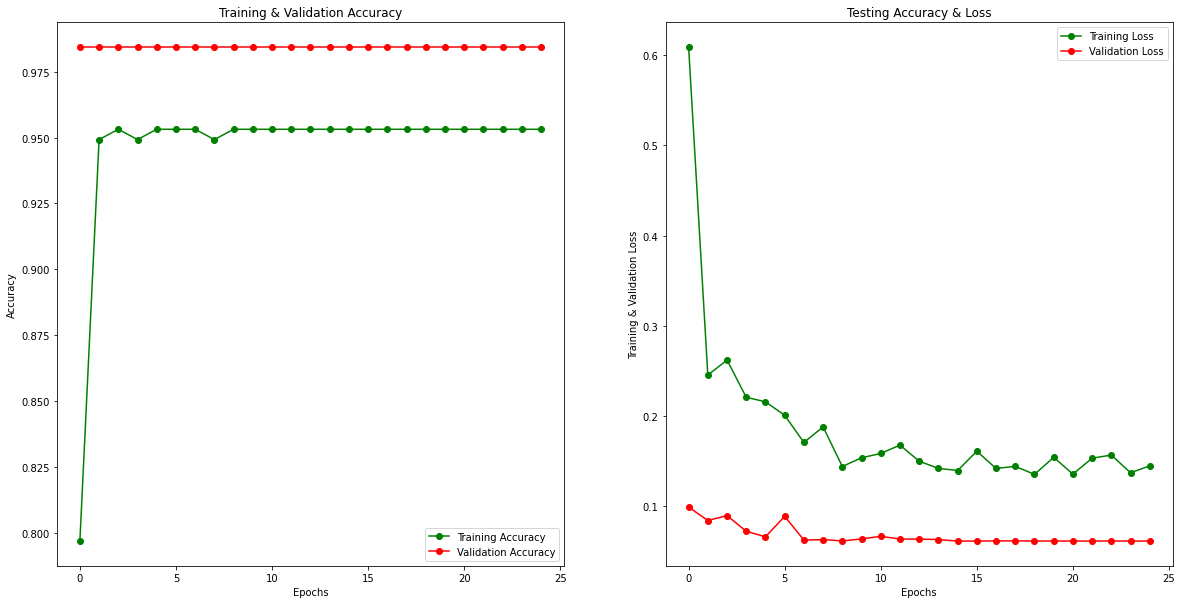

In [53]:
epochs = [i for i in range(25)]
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20, 10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'g-o', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")

plt.show()

In [54]:
predict_y = model.predict(Xte)
predictions = []
true_test_y = []

for i in range(len(predict_y)):
    predictions.extend(np.where(predict_y[i] == max(predict_y[i]))[0])
    true_test_y.extend(np.where(test_y[i] == max(test_y[i]))[0])

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapData

In [55]:
print(classification_report(true_test_y, predictions))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        77
           1       0.00      0.00      0.00         3

    accuracy                           0.96        80
   macro avg       0.48      0.50      0.49        80
weighted avg       0.93      0.96      0.94        80



c:\ProgramData\Anaconda3\envs\test2\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\test2\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\test2\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
correct = []
incorrect = []

for i in range(len(true_test_y)):
    if (true_test_y[i] == predictions[i]):
        correct.append(i)
    else:
        incorrect.append(i)

Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DestroyResourceOp in device /job:localhos

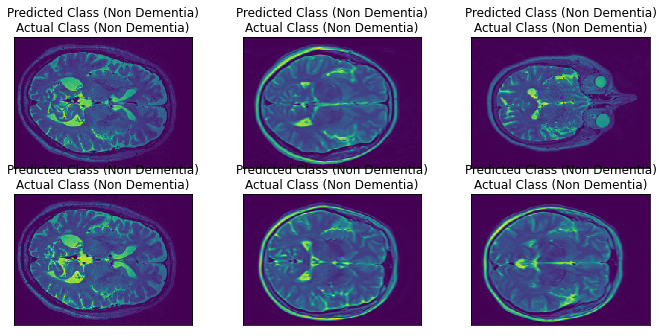

In [57]:
i = 0

for c in correct[:6]:
    plt.subplot(2, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_x_image[c], interpolation='none')

    if (predictions[c] == 0):
        predict_class = "Non Dementia"
    elif (predictions[c] == 1):
        predict_class = "Vey Mild Dementia"
    elif (predictions[c] == 2):
        predict_class = "Mild Dementia"
    else:
        predict_class = "Moderate Dementia"

    if (true_test_y[c] == 0):
        true_class = "Non Dementia"
    elif (true_test_y[c] == 1):
        true_class = "Vey Mild Dementia"
    elif (true_test_y[c] == 2):
        true_class = "Mild Dementia"
    else:
        true_class = "Moderate Dementia"

    plt.title("Predicted Class ({})\nActual Class ({})".format(predict_class, true_class))
    plt.subplots_adjust(top = 7, bottom = 6, left = 5.5, right = 7)

    i += 1

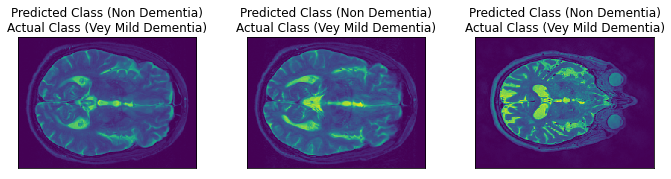

In [58]:
i = 0

for c in incorrect[:6]:
    plt.subplot(2, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_x_image[c], interpolation='none')

    if (predictions[c] == 0):
        predict_class = "Non Dementia"
    elif (predictions[c] == 1):
        predict_class = "Vey Mild Dementia"
    elif (predictions[c] == 2):
        predict_class = "Mild Dementia"
    else:
        predict_class = "Moderate Dementia"

    if (true_test_y[c] == 0):
        true_class = "Non Dementia"
    elif (true_test_y[c] == 1):
        true_class = "Vey Mild Dementia"
    elif (true_test_y[c] == 2):
        true_class = "Mild Dementia"
    else:
        true_class = "Moderate Dementia"

    plt.title("Predicted Class ({})\nActual Class ({})".format(predict_class, true_class))
    plt.subplots_adjust(top = 7, bottom = 6, left = 5.5, right = 7)

    i += 1